In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd https://drive.google.com/drive/folders/1ZKO5h6PTkB6XSbH4ci-XMAxcTme2KyXv?usp=drive_link

[Errno 2] No such file or directory: 'https://drive.google.com/drive/folders/1ZKO5h6PTkB6XSbH4ci-XMAxcTme2KyXv?usp=drive_link'
/content


In [3]:
import pandas as pd
import spacy
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import joblib
from wordcloud import WordCloud
# Import necessary libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# Improved Text Preprocessing Function
def improved_text_preprocess(text):
    if not isinstance(text, str):
        return ''

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [6]:
# Define keywords for different aspects
performance_keywords = ['speed', 'read', 'write', 'transfer', 'performance']
quality_keywords = ['quality', 'built', 'design', 'durability', 'reliable']
packaging_keywords = ['packaging', 'delivery', 'arrived', 'shipping', 'package']

# Function to extract aspects from review text
def extract_aspects(review_text, stars):
    if isinstance(review_text, str):
        review_text = review_text.lower()
        tokens = word_tokenize(review_text)
        filtered_tokens = [word for word in tokens if word not in stopwords.words('english')]

        aspects = []

        if any(keyword in filtered_tokens for keyword in performance_keywords):
            aspects.append('Performance')
        if any(keyword in filtered_tokens for keyword in quality_keywords):
            aspects.append('Quality')
        if any(keyword in filtered_tokens for keyword in packaging_keywords):
            aspects.append('Packaging & Delivery')

        if not aspects:
            if pd.isna(stars):
                aspects.append('NULL')
            elif int(stars) >= 4:
                aspects.append('Positive')
            elif int(stars) <= 2:
                aspects.append('Negative')
            else:
                aspects.append('Neutral')
    else:
        aspects = ['NULL']

    return ', '.join(aspects) if aspects else 'NULL'




In [7]:
# Improved aspect extraction function
def extract_aspects_and_sentiments(review):
    doc = nlp(review)
    aspects = {}
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN'] and len(token.text) > 2:
            aspect = token.lemma_.lower()
            if aspect not in aspects:
                aspects[aspect] = {'count': 0, 'sentiment': 0}
            aspects[aspect]['count'] += 1
            aspects[aspect]['sentiment'] += TextBlob(token.sent.text).sentiment.polarity

    for aspect in aspects:
        aspects[aspect]['sentiment'] /= aspects[aspect]['count']

    return aspects

In [8]:
# Custom aspect filter function
def filter_aspects(aspects, min_count=10, exclude_words=['i', 'problem', 'issue', 'that', 'purchase', 'you', 'reality', 'it', 'thing', 'one', 'work']):
    return {aspect: data for aspect, data in aspects.items()
            if aspect not in exclude_words
            and data['count'] >= min_count}

In [9]:
# Function to convert sentiment score to words
def sentiment_in_words(score):
    if score > 0.5:
        return f"Very Positive ({score:.2f})"
    elif score > 0.2:
        return f"Positive ({score:.2f})"
    elif score > 0:
        return f"Somewhat Positive ({score:.2f})"
    elif score == 0:
        return f"Neutral ({score:.2f})"
    elif score > -0.2:
        return f"Somewhat Negative ({score:.2f})"
    elif score > -0.5:
        return f"Moderately Negative ({score:.2f})"
    else:
        return f"Very Negative ({score:.2f})"

In [10]:
# Function to create word cloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Main processing
if __name__ == "__main__":
    # Load your dataset
    df = pd.read_csv(r'/content/drive/MyDrive/opinion mining/op_mining/amazon_reviews(AutoRecovered).csv')

In [11]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,stars,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4,Four Stars,1406073600,23-07-2014,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5,MOAR SPACE!!!,1382659200,25-10-2013,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4,nothing to really say....,1356220800,23-12-2012,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5,Great buy at this price!!! *** UPDATE,1384992000,21-11-2013,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5,best deal around,1373673600,13-07-2013,513,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",I bought this Sandisk 16GB Class 10 to use wit...,1,Do not waste your money.,1374537600,23-07-2013,503,0,0
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",Used this for extending the capabilities of my...,5,Great item!,1377129600,22-08-2013,473,0,0
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",Great card that is very fast and reliable. It ...,5,Fast and reliable memory card,1396224000,31-03-2014,252,0,0
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",Good amount of space for the stuff I want to d...,5,Great little card,1379289600,16-09-2013,448,0,0


In [12]:
# Feature Extraction technique

# Apply improved text preprocessing
df['processed_review'] = df['reviewText'].apply(improved_text_preprocess)
df = df.dropna(subset=['processed_review'])
df = df.drop_duplicates(subset=['processed_review'])

# Limit the length of reviews
max_length = 500
df['processed_review'] = df['processed_review'].apply(lambda x: ' '.join(x.split()[:max_length]))

# Extract aspects
df['aspect'] = df.apply(lambda row: extract_aspects(row['reviewText'], row['stars']), axis=1)

# Extract aspects and sentiments
df['aspects_sentiments'] = df['processed_review'].apply(extract_aspects_and_sentiments)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['processed_review'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [13]:
df['aspect']

,aspect
0,Positive
1,Positive
2,Positive
3,Quality
4,Packaging & Delivery
...,...
4910,Performance
4911,Positive
4912,Quality
4913,Positive


In [14]:

# Combine all aspects
all_aspects = {}

for aspects in df['aspects_sentiments']:
     for aspect, data in aspects.items():
            if aspect not in all_aspects:
                all_aspects[aspect] = {'count': 0, 'positive': 0, 'negative': 0, 'neutral': 0}

            all_aspects[aspect]['count'] += data['count']
            if data['sentiment'] > 0.1:
                all_aspects[aspect]['positive'] += data['count']
            elif data['sentiment'] < -0.1:
                all_aspects[aspect]['negative'] += data['count']
            else:
                all_aspects[aspect]['neutral'] += data['count']




 # Filter and sort aspects
filtered_aspects = filter_aspects(all_aspects)
sorted_aspects = sorted(filtered_aspects.items(), key=lambda x: x[1]['count'], reverse=True)

In [15]:
 # Print top 10 aspects and their sentiments
for aspect, data in sorted_aspects[:20]:
    print(f"Aspect: {aspect}")
    print(f"Positive: {data['positive']}, Negative: {data['negative']}, Neutral: {data['neutral']}")
    print()


Aspect: card
Positive: 3814, Negative: 220, Neutral: 1435

Aspect: phone
Positive: 1311, Negative: 71, Neutral: 515

Aspect: memory
Positive: 976, Negative: 48, Neutral: 353

Aspect: sandisk
Positive: 852, Negative: 79, Neutral: 365

Aspect: galaxy
Positive: 713, Negative: 48, Neutral: 194

Aspect: speed
Positive: 674, Negative: 15, Neutral: 196

Aspect: price
Positive: 751, Negative: 10, Neutral: 110

Aspect: samsung
Positive: 610, Negative: 43, Neutral: 176

Aspect: storage
Positive: 571, Negative: 17, Neutral: 160

Aspect: video
Positive: 506, Negative: 28, Neutral: 177

Aspect: product
Positive: 523, Negative: 29, Neutral: 136

Aspect: tablet
Positive: 525, Negative: 16, Neutral: 136

Aspect: camera
Positive: 452, Negative: 18, Neutral: 170

Aspect: use
Positive: 471, Negative: 20, Neutral: 138

Aspect: class
Positive: 427, Negative: 23, Neutral: 177

Aspect: music
Positive: 445, Negative: 20, Neutral: 137

Aspect: device
Positive: 425, Negative: 22, Neutral: 135

Aspect: file
Posi

In [16]:

# Save the processed data
df_final = pd.concat([df, tfidf_df], axis=1)
df_final.to_csv('processed_amazon_reviews.csv', index=False)

    # Save the TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [17]:
new_df = pd.read_csv('processed_amazon_reviews.csv')

In [18]:
new_df

,reviewerID,asin,reviewerName,helpful,reviewText,stars,summary,unixReviewTime,reviewTime,day_diff,...,zillion,zip,zippy,zone,zoning,zoom,zte,ztpad,zumo,zune
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1.406074e+09,23-07-2014,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1.382659e+09,25-10-2013,409.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1.356221e+09,23-12-2012,715.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1.384992e+09,21-11-2013,382.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1.373674e+09,13-07-2013,513.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",Good amount of space for the stuff I want to d...,5.0,Great little card,1.379290e+09,16-09-2013,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4911,A8KGFTFQ86IBR,B007WTAJTO,Zza,"[0, 0]",I've heard bad things about this 64gb Micro SD...,5.0,So far so good.,1.388621e+09,01-02-2014,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


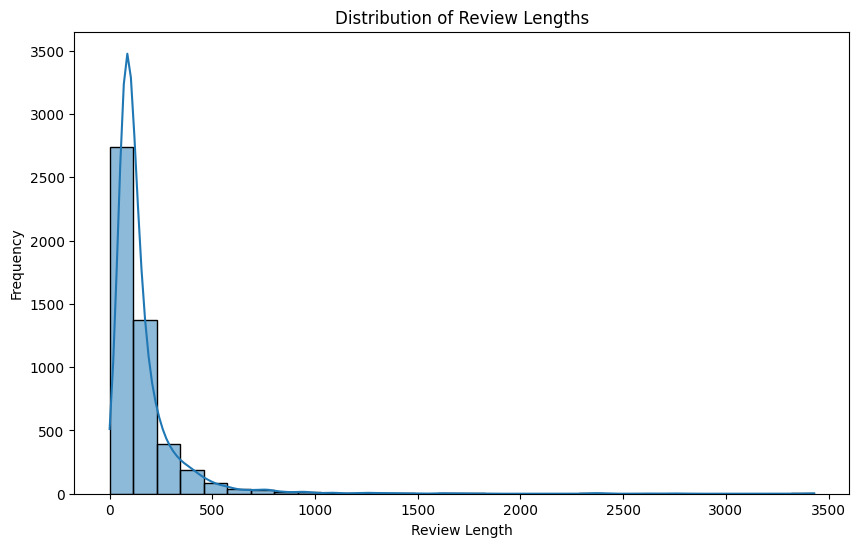

In [19]:
 # Visualization
    # Distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['processed_review'].apply(len), kde=True, bins=30)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


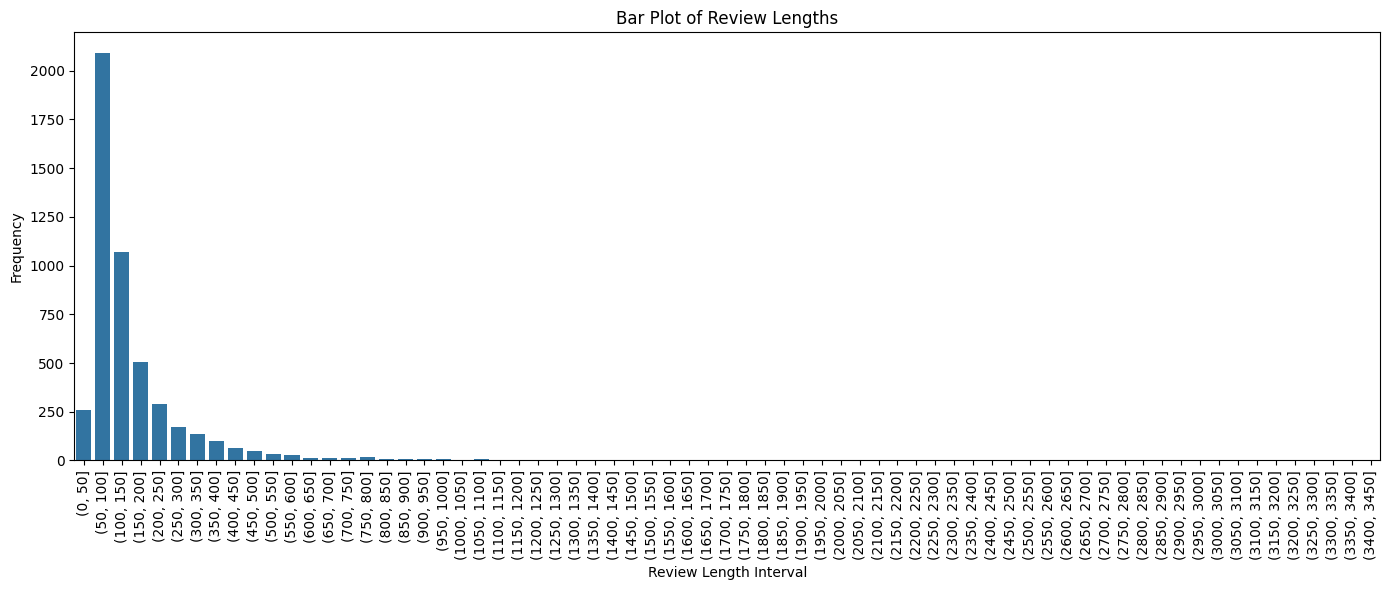

In [20]:
# Function to safely get length of a string
def safe_len(x):

    return len(str(x)) if pd.notna(x) else 0

# Bar plot of review lengths
plt.figure(figsize=(14, 6))
lengths = new_df['processed_review'].apply(safe_len)
length_intervals = pd.cut(lengths, bins=range(0, lengths.max() + 50, 50))
sns.countplot(x=length_intervals, data=pd.DataFrame({'length_intervals': length_intervals}))
plt.title('Bar Plot of Review Lengths')
plt.xlabel('Review Length Interval')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [21]:
# Display unique values in categorical columns
categorical_columns = new_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Unique values in {col}:")
    print(new_df[col].value_counts())
    print("\n")

Unique values in reviewerID:
reviewerID
A3SBTW3WS4IQSN    1
A2DIQTZPF26T1L    1
A21MMTDAFAUPQT    1
AM1T7QCP4B8EW     1
A3T6Z4XWXWGEEN    1
                 ..
A12R3YGEHW7D8G    1
AVKDNIKIX452Y     1
A35ZLKM1A86J68    1
A2MDYGR9DM85LJ    1
A8KGFTFQ86IBR     1
Name: count, Length: 4912, dtype: int64


Unique values in asin:
asin
B007WTAJTO    4912
Name: count, dtype: int64


Unique values in reviewerName:
reviewerName
Amazon Customer    121
David               10
Michael              9
Chris                8
Mike                 7
                  ... 
Gaven fechter        1
G. Becker            1
GB                   1
G-bury               1
Zza                  1
Name: count, Length: 4591, dtype: int64


Unique values in helpful:
helpful
[0, 0]          4357
[1, 1]           266
[0, 1]           114
[1, 2]            46
[2, 2]            28
[0, 2]            22
[1, 3]             9
[3, 3]             7
[0, 3]             6
[5, 5]             5
[4, 4]             5
[3, 4]             

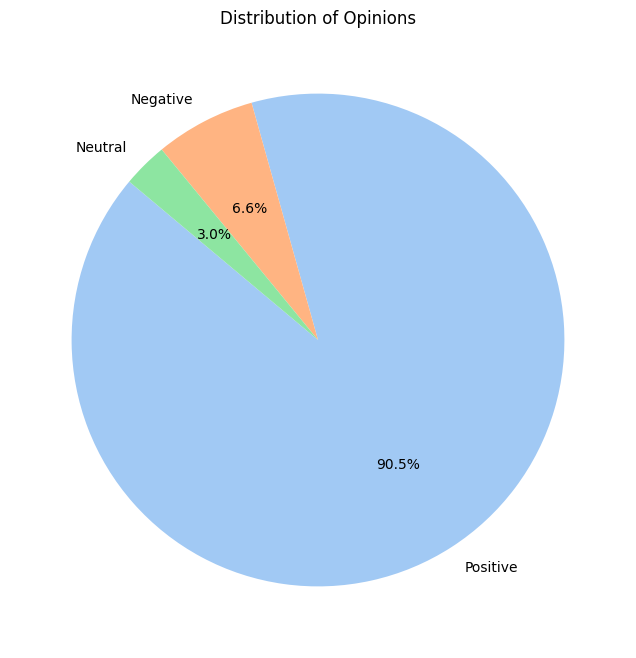

In [22]:
# Opinion distribution
new_df['opinion'] = new_df['stars'].apply(lambda x: 1 if x > 3 else (-1 if x < 3 else 0))
oc = new_df['opinion'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(oc, labels=['Positive', 'Negative', 'Neutral'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Distribution of Opinions')
plt.show()

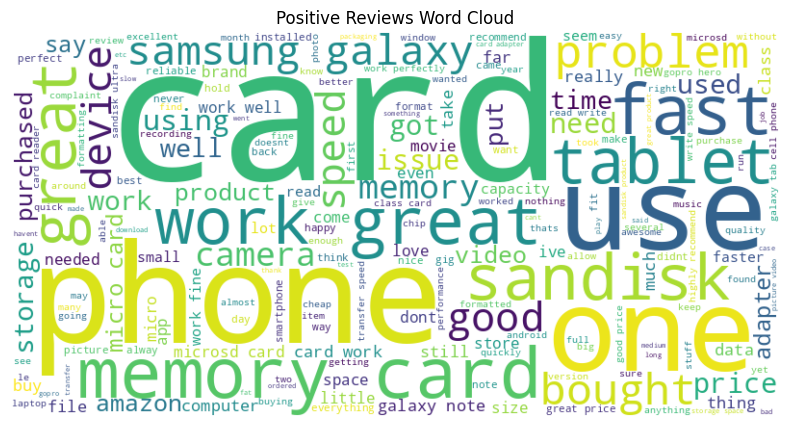

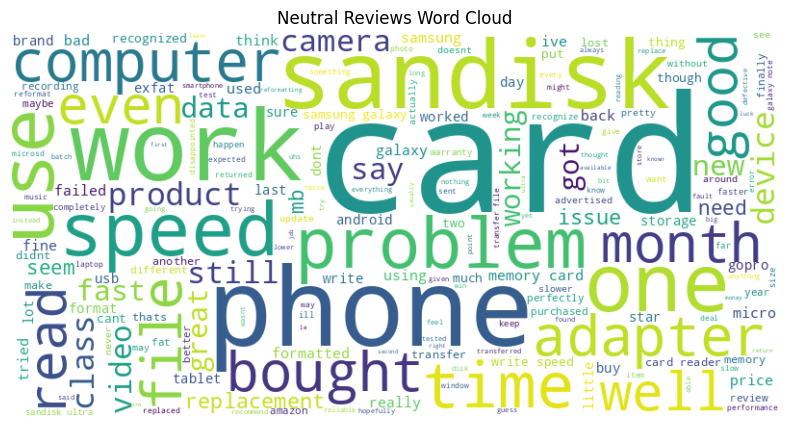

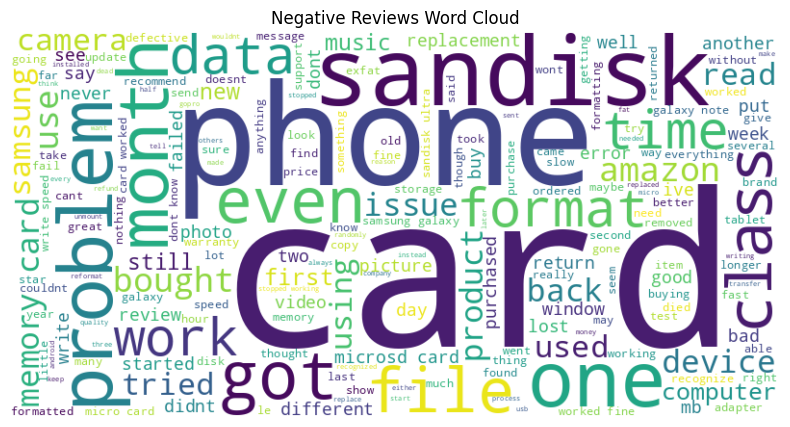

In [23]:
# Function to create word cloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Word clouds
positive_text = ' '.join(new_df[new_df['opinion'] == 1]['processed_review'].dropna().astype(str))
neutral_text = ' '.join(new_df[new_df['opinion'] == 0]['processed_review'].dropna().astype(str))
negative_text = ' '.join(new_df[new_df['opinion'] == -1]['processed_review'].dropna().astype(str))

create_wordcloud(positive_text, 'Positive Reviews Word Cloud')
create_wordcloud(neutral_text, 'Neutral Reviews Word Cloud')
create_wordcloud(negative_text, 'Negative Reviews Word Cloud')

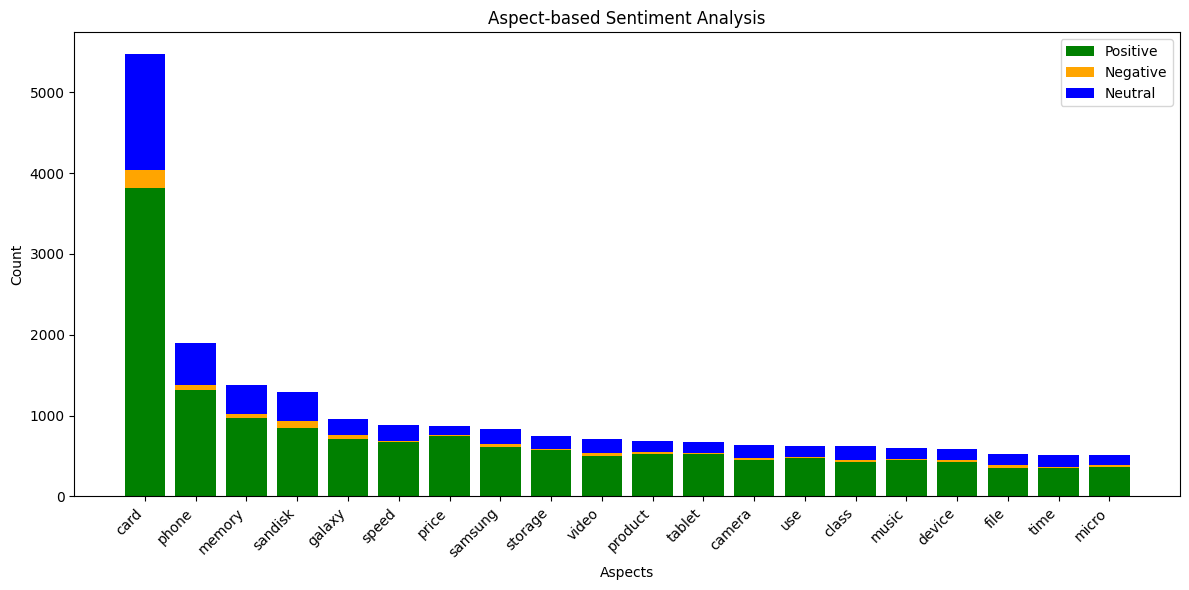

In [24]:
# Aspect-based sentiment analysis visualization
top_aspects = sorted_aspects[:20]
aspects = [aspect for aspect, _ in top_aspects]
positive = [data['positive'] for _, data in top_aspects]
negative = [data['negative'] for _, data in top_aspects]
neutral = [data['neutral'] for _, data in top_aspects]

plt.figure(figsize=(12, 6))
plt.bar(aspects, positive, color='green', label='Positive')
plt.bar(aspects, negative, bottom=positive, color='orange', label='Negative')
plt.bar(aspects, neutral, bottom=[i+j for i,j in zip(positive, negative)], color='blue', label='Neutral')

plt.xlabel('Aspects')
plt.ylabel('Count')
plt.title('Aspect-based Sentiment Analysis')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [25]:
# Ensure there are no missing values in the opinion column
new_df = new_df.dropna(subset=['opinion'])

# Convert tfidf_matrix to a dense matrix and then to a DataFrame
X_dense = pd.DataFrame(tfidf_matrix.toarray())

# Align the indices of X (X_dense) and y (new_dt['opinion'])
common_indices = new_df.index.intersection(X_dense.index)
new_df = new_df.loc[common_indices].reset_index(drop=True)
X_dense = X_dense.loc[common_indices].reset_index(drop=True)

# Verify all elements in X_dense are numeric
assert X_dense.applymap(np.isreal).all().all(), "Non-numeric values found in X_dense"

<ipython-input-25-c298a86c7ac7>:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  assert X_dense.applymap(np.isreal).all().all(), "Non-numeric values found in X_dense"


In [26]:
y = new_df['opinion']

# Verify the lengths of X and y
assert len(X_dense) == len(y), f"Inconsistent lengths: len(X_dense)={len(X_dense)}, len(y)={len(y)}"

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.2, random_state=42)


In [27]:
# Hyperparameter Tuning for SVM and Random Forest using GridSearchCV

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01, 0.001]
}

# GridSearchCV for SVM
grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, refit=True, verbose=1, cv=5)
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [28]:
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, refit=True, verbose=1, cv=5)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [29]:
# Train and evaluate models
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': best_rf,
    'SVM': best_svm
}

# Cross-validation and Model Evaluation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'{name} Cross-Validation Accuracy: {cv_scores.mean():.4f}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Classification Report for {name}:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix for {name}:\n{confusion_matrix(y_test, y_pred)}\n')

Naive Bayes Cross-Validation Accuracy: 0.9081
Naive Bayes Accuracy: 0.8932


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        67
           0       0.00      0.00      0.00        38
           1       0.89      1.00      0.94       878

    accuracy                           0.89       983
   macro avg       0.30      0.33      0.31       983
weighted avg       0.80      0.89      0.84       983

Confusion Matrix for Naive Bayes:
[[  0   0  67]
 [  0   0  38]
 [  0   0 878]]

Decision Tree Cross-Validation Accuracy: 0.8865
Decision Tree Accuracy: 0.8769
Classification Report for Decision Tree:
              precision    recall  f1-score   support

          -1       0.39      0.28      0.33        67
           0       0.09      0.05      0.07        38
           1       0.92      0.96      0.94       878

    accuracy                           0.88       983
   macro avg       0.47      0.43      0.44       983
weighted avg       0.85      0.88      0.86       983

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Cross-Validation Accuracy: 0.9318
SVM Accuracy: 0.9207
Classification Report for SVM:
              precision    recall  f1-score   support

          -1       0.82      0.48      0.60        67
           0       0.00      0.00      0.00        38
           1       0.92      0.99      0.96       878

    accuracy                           0.92       983
   macro avg       0.58      0.49      0.52       983
weighted avg       0.88      0.92      0.90       983

Confusion Matrix for SVM:
[[ 32   0  35]
 [  2   0  36]
 [  5   0 873]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


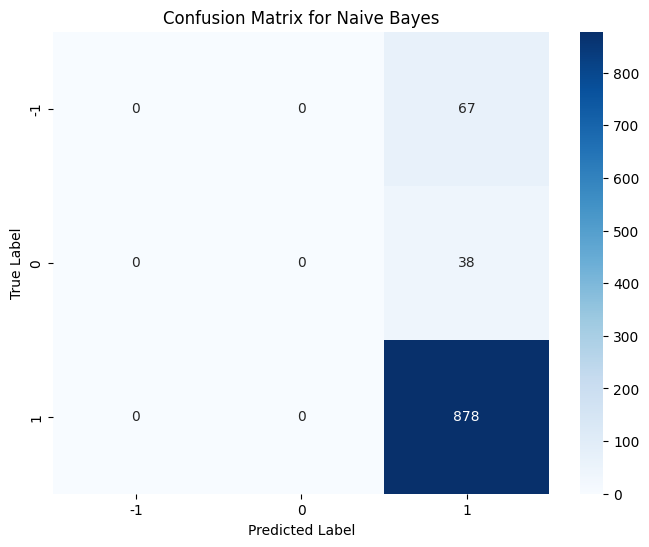

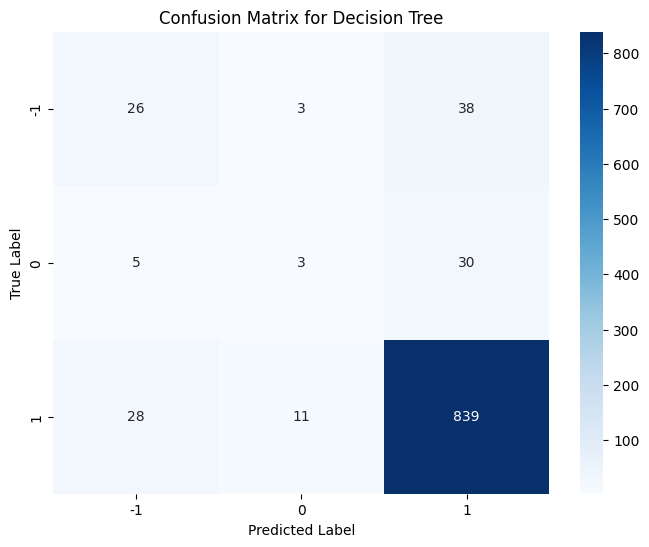

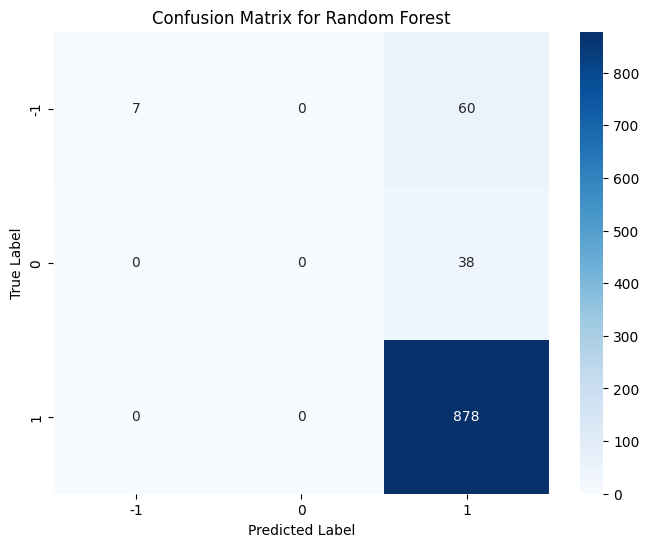

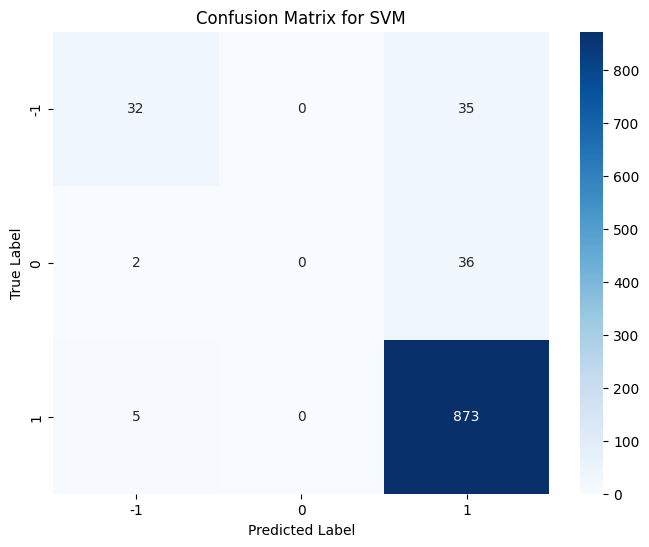

In [30]:
from sklearn.metrics import confusion_matrix

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, model_name, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Define labels for the classes (adjust if needed)
labels = [-1, 0, 1]

# Model predictions and confusion matrices
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': best_rf,
    'SVM': best_svm
}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on the test set
    cm = confusion_matrix(y_test, y_pred, labels=labels)  # Compute confusion matrix
    plot_confusion_matrix(cm, name, labels)  # Plot the confusion matrix


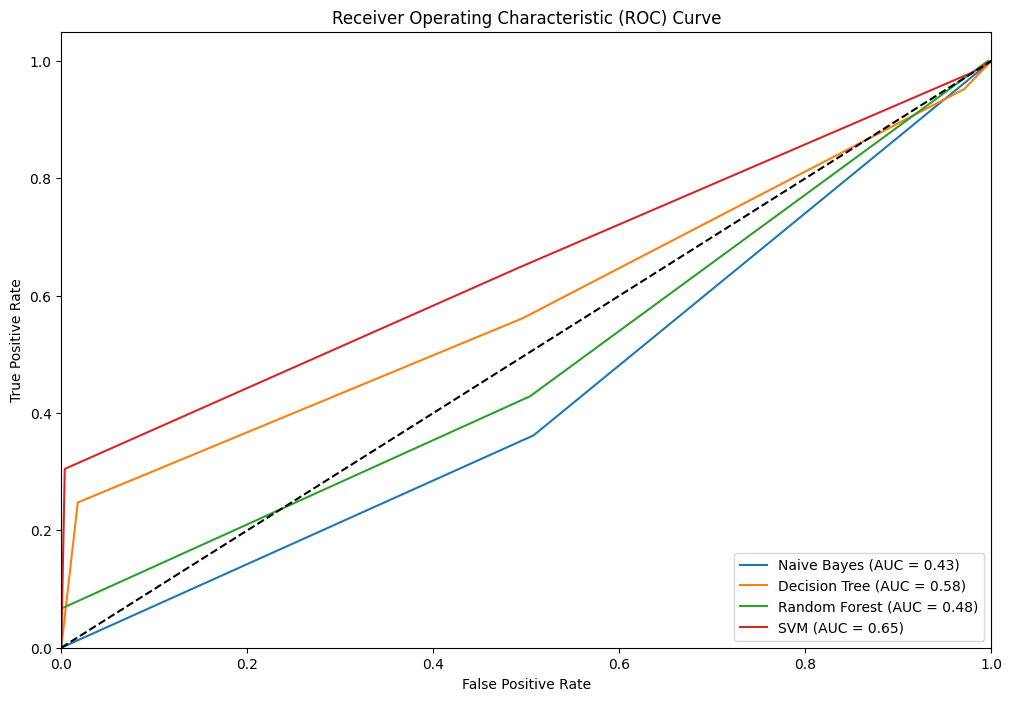

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming y_test has classes: -1, 0, 1
classes = np.unique(y_test)
n_classes = len(classes)

# Binarize the output for ROC computation
y_test_binarized = label_binarize(y_test, classes=classes)

# Plot setup
plt.figure(figsize=(12, 8))

for name, model in models.items():
    y_prob = model.predict(X_test)

    # If y_prob is one-dimensional, reshape it to two dimensions
    if y_prob.ndim == 1:
        y_prob = np.vstack([1 - y_prob, y_prob]).T

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(min(n_classes, y_prob.shape[1])):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized[:, :y_prob.shape[1]].ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot the micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')

# Diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')

# Plot configurations
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





In [32]:
# Save the Best Model using Joblib
joblib.dump(best_rf, 'best_rf_model.joblib')
tfidf = joblib.load('tfidf_vectorizer.joblib')

In [48]:
import re
import joblib
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import numpy as np

# Keywords for aspects
aspect_keywords = {
    "performance": ["speed", "performance", "fast", "slow"],
    "packaging": ["packaging", "box", "package"],
    "price": ["price", "cost", "expensive", "cheap"],
    "quality": ["quality", "build", "durability", "sturdy"],
    "design": ["design", "style", "appearance", "looks"]
}

# Function to preprocess text
def text_preprocess(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Function to extract aspects and predict sentiment
def predict_opinion_and_aspects(review, model, tfidf):
    # Preprocess the review
    processed_review = text_preprocess(review)

    # Transform the processed review using the TF-IDF vectorizer
    review_tfidf = tfidf.transform([processed_review])

    # Predict the overall opinion using the trained model
    opinion = model.predict(review_tfidf)[0]

    # Tokenize the review into sentences
    sentences = sent_tokenize(review)  # Use original review text for aspect detection

    # Initialize aspect sentiment dictionaries
    aspect_sentiments = {aspect: [] for aspect in aspect_keywords}

    # Analyze each sentence
    for sentence in sentences:
        sentence_words = set(word_tokenize(sentence.lower()))
        for aspect, keywords in aspect_keywords.items():
            if any(keyword in sentence_words for keyword in keywords):
                # Compute sentiment score for this sentence
                sentiment_score = TextBlob(sentence).sentiment.polarity
                aspect_sentiments[aspect].append(sentiment_score)

    # Aggregate sentiment scores for each aspect
    final_aspect_sentiments = []
    for aspect, scores in aspect_sentiments.items():
        if scores:
            avg_score = np.mean(scores)
        else:
            avg_score = 0  # Neutral if aspect not mentioned
        final_aspect_sentiments.append((aspect, avg_score))

    return opinion, final_aspect_sentiments

# Main function to get user input and output predictions
def main():
    # Load the model and tfidf vectorizer
    model = joblib.load('best_rf_model.joblib')  # Your trained model
    tfidf = joblib.load('tfidf_vectorizer.joblib')

    while True:
        # Get user input
        user_input = input("Enter a product review (or type 'exit' to quit): ")

        if user_input.lower() == 'exit':
            print("Exiting the program. Goodbye!")
            break

        # Predict opinion and aspects
        opinion, aspects = predict_opinion_and_aspects(user_input, model, tfidf)

        # Output the results
        opinion_text = "Positive" if opinion == 1 else "Negative" if opinion == -1 else "Neutral"
        #print(f"\nPredicted Opinion: {opinion_text}")
        print("Aspects based Sentiment Analysis:")

        for aspect, sentiment_score in aspects:
            sentiment_text = ("Very Positive" if sentiment_score > 0.5 else
                              "Positive" if sentiment_score > 0 else
                              "Neutral" if sentiment_score == 0 else
                              "Negative" if sentiment_score > -0.5 else
                              "Very Negative")
            print(f" - {aspect}: {sentiment_text} ({sentiment_score:+.1f})")
        print()

if __name__ == "__main__":
    main()


Enter a product review (or type 'exit' to quit): I am really impressed with the speed of this laptop. However, the packaging was not very good, and the delivery was delayed.
Aspects based Sentiment Analysis:
 - performance: Very Positive (+1.0)
 - packaging: Negative (-0.3)
 - price: Neutral (+0.0)
 - quality: Neutral (+0.0)
 - design: Neutral (+0.0)

Enter a product review (or type 'exit' to quit):  just received my new phone, and I'm absolutely thrilled with its performance. The battery life is excellent, and the camera quality is top-notch. The packaging was secure, and it arrived on time. Overall, it's a fantastic purchase.
Aspects based Sentiment Analysis:
 - performance: Positive (+0.4)
 - packaging: Positive (+0.4)
 - price: Neutral (+0.0)
 - quality: Very Positive (+1.0)
 - design: Neutral (+0.0)

Enter a product review (or type 'exit' to quit): I was disappointed with the laptop I ordered. The performance is sluggish, and the screen has a lot of dead pixels. The delivery was d